## Introduction to Image Variation

Amazon Nova Canvas offers a task type called "IMAGE_VARIATION". Image variation is a versatile capability with a range of uses. Depending on the parameters you provide, image variation can help you...

1. Produce new images of a specific subject based on images of that subject
2. Guide the model to produce images in a particular visual style by providing examples of that style
3. Mix and combine styles from multple reference images to create unique styles

This opens up new creative possibilities for generating sophisticated and engaging images without the need for complex prompt engineering or model fine-tuning.

### Use Case

OctankFashion can leverage the Image Variation feature to create unique designs. For example, they can start with a reference image of a wedding dress design generate many different variations with subtle or drastic changes, blending the original design with the stylistic elements from the reference images. This allows them to iterate on concepts more rapidly, exploring different silhouettes, textures, and color palettes without the time and cost of physical prototyping.


<div class="alert alert-block alert-warning">
<b>Prerequisites:</b> Please run the prerequiresites <b>00-prerequisites.ipynb</b> first before proceeding.
</div>


In [1]:
import io
import json
import base64
import boto3
from botocore.config import Config
from PIL import Image
from utils import save_image, plot_images, plot_images_for_comparison

bedrock_runtime_client = boto3.client(
    "bedrock-runtime",
    region_name="us-east-1",
    config=Config(
        read_timeout=5 * 60
    ),  # IMPORTANT: Increase the read timeout to 5 minutes to support longer operations.
)
image_generation_model_id = "amazon.nova-canvas-v1:0"
output_dir = "output"

### Example 1: Creating variants of an input image

To demostrate the power of image variation, we'll generate two images with the same prompt and seed values. The first image will be generated without any reference image. The second will use the reference image below. Run the cells below. The generated images will be saved to the "output" folder.

<img src="data/wedding_dress.png" height="400">


In [2]:
# Define the main input parameters.
reference_image_path = "data/wedding_dress.png"
similarity_strength = (
    0.7  # How strongly the input images influence the output. From 0.2 through 1.
)

text = "A pink wedding dress"

seed = 1

Generating image without a reference image...
Saved image without reference to output/05-image-variation_no-reference.png
Generating image with a reference image...
Saved image with reference to output/05-image-variation_with-reference.png
Prompt: A pink wedding dress



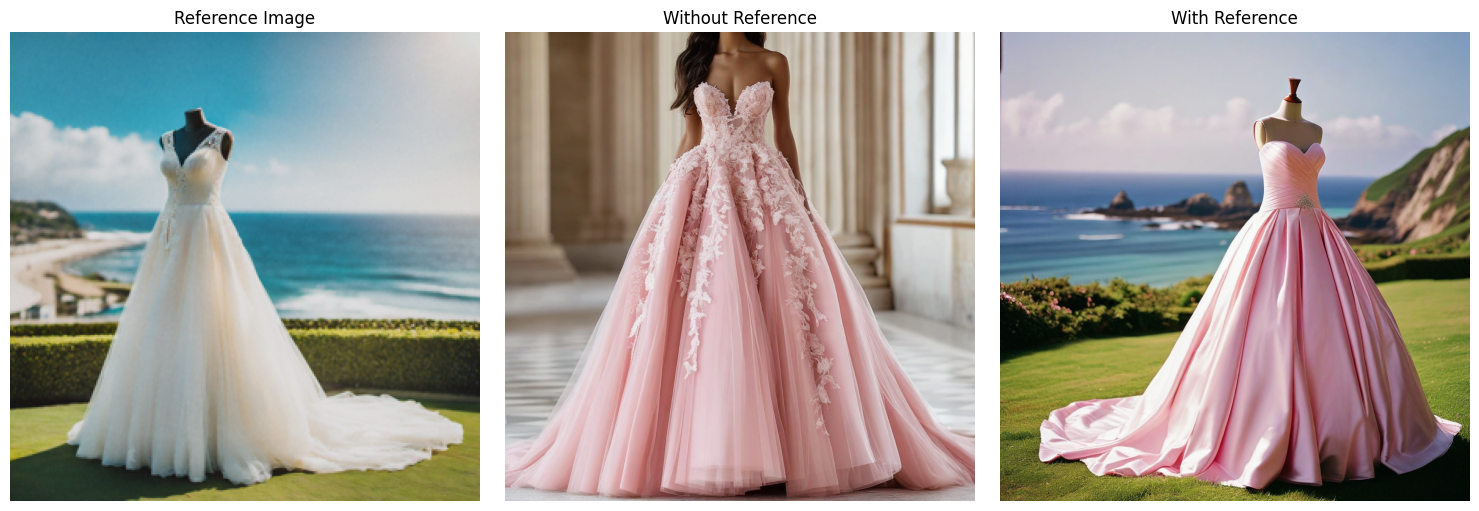

In [3]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

print("Generating image without a reference image...")

# Generate image without reference
response_without_ref = bedrock_runtime_client.invoke_model(
    body=json.dumps(
        {
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {"text": text},
            "imageGenerationConfig": {
                "numberOfImages": 1,  # Number of images to generate, up to 5.
                "cfgScale": 6.5,  # How closely the prompt will be followed
                "seed": seed,  # Any number from 0 through 858,993,459
                "quality": "standard",  # Either "standard" or "premium". Defaults to "standard".
            },
        }
    ),
    modelId=image_generation_model_id,
    accept="application/json",
    contentType="application/json",
)

response_body_without_ref = json.loads(response_without_ref.get("body").read())

images_without_ref = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body_without_ref.get("images")
]

# Save output
image_without_reference_path = f"{output_dir}/05-image-variation_no-reference.png"
save_image(response_body_without_ref.get("images")[0], image_without_reference_path)
print(f"Saved image without reference to {image_without_reference_path}")

print("Generating image with a reference image...")

# Generate image with referece (Image variation feature)
response_with_ref = bedrock_runtime_client.invoke_model(
    body=json.dumps(
        {
            "taskType": "IMAGE_VARIATION",
            "imageVariationParams": {
                "text": text,
                "images": [
                    reference_image_base64
                ],  # May provide up to 5 reference images here
                "similarityStrength": similarity_strength,  # How strongly the input images influence the output. From 0.2 through 1.
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,  # Number of images to generate, up to 5.
                "cfgScale": 6.5,  # How closely the prompt will be followed
                "seed": seed,  # Any number from 0 through 858,993,459
                "quality": "standard",  # Either "standard" or "premium". Defaults to "standard".
            },
        }
    ),
    modelId=image_generation_model_id,
    accept="application/json",
    contentType="application/json",
)

response_body_with_ref = json.loads(response_with_ref.get("body").read())

images_with_ref = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body_with_ref.get("images")
]

# Save output
image_with_reference_path = f"{output_dir}/05-image-variation_with-reference.png"
save_image(response_body_with_ref.get("images")[0], image_with_reference_path)
print(f"Saved image with reference to {image_with_reference_path}")

# Plot output
plot_images_for_comparison(
    ref_image_path=reference_image_path,
    base_images=images_without_ref,
    custom_images=images_with_ref,
    prompt=text,
)

### Example 2: Using image variation for style transfer

The image variation feature can be used to influence the visual style of the generated image, a process often referred to as "style transfer". By using reference images in a particular style, such as a sketch or a painting, and using a moderate `similarityStrength` value and a strong `cfgScale` value, the generated image will inherit that style while still following the content of the text prompt. This powerful feature enables users to create images with desired styles without having to craft elaborate style descriptions within the text prompt.

Note, the interplay between `similarityStrength` and `cfgScale` means you may have to experiment with both of these values in order to achieve the right balance for a successful style transfer.

We'll demonstrate style transfer using the reference image below. Run the cells below. The generated images will be saved to the "output" folder.

<img src="data/designer_sketch_dress.png" height="400">


In [4]:
# Define the main input parameters.
reference_image_path = "data/designer_sketch_dress.png"
similarity_strength = (
    0.5  # How strongly the input images influence the output. From 0.2 through 1.
)

text = "a wedding tuxedo for groom"

seed = 1

Generating image without a reference image...
Saved image without reference to output/05-image-variation_style-transfer_no-reference.png
Generating image with a reference image...
Saved image with reference to output/05-image-variation_style-transfer_with-reference.png
Prompt: a wedding tuxedo for groom



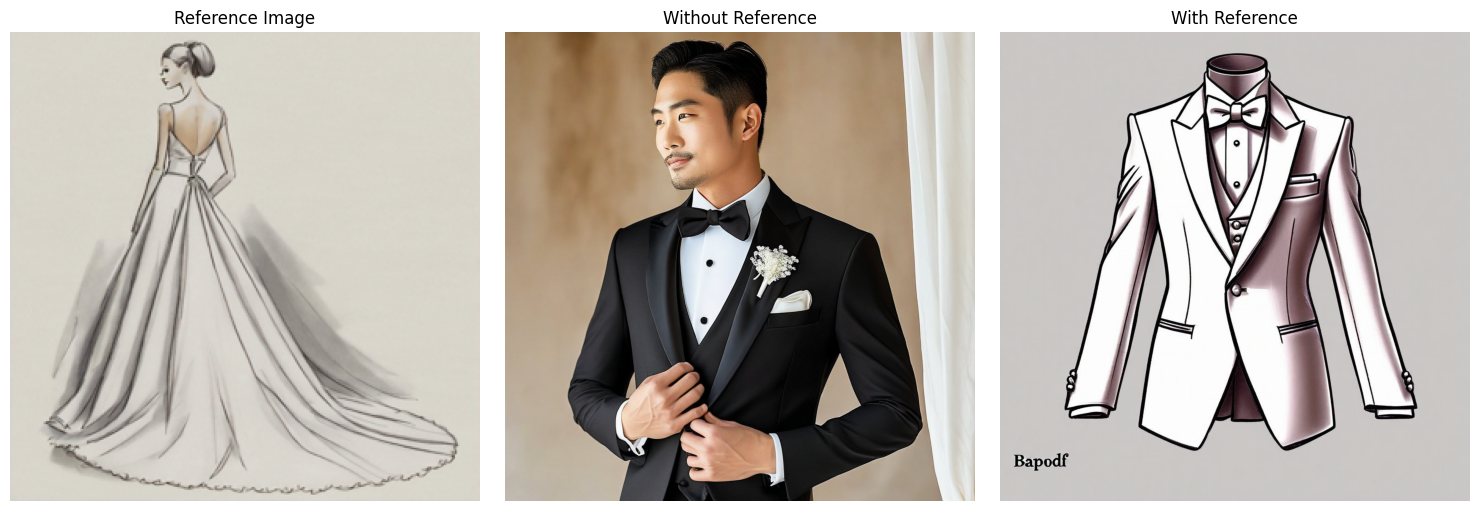

In [5]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

print("Generating image without a reference image...")

# Generate image without reference
response_without_ref = bedrock_runtime_client.invoke_model(
    body=json.dumps(
        {
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {"text": text},
            "imageGenerationConfig": {
                "numberOfImages": 1,  # Number of images to generate, up to 5
                "width": 1024,
                "height": 1024,
                "cfgScale": 6.5,  # How closely the prompt will be followed
                "seed": seed,
                "quality": "standard",  # Quality of either "standard" or "premium"
            },
        }
    ),
    modelId=image_generation_model_id,
    accept="application/json",
    contentType="application/json",
)

response_body_without_ref = json.loads(response_without_ref.get("body").read())

images_without_ref = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body_without_ref.get("images")
]

# Save output
image_without_reference_path = (
    f"{output_dir}/05-image-variation_style-transfer_no-reference.png"
)
save_image(response_body_without_ref.get("images")[0], image_without_reference_path)
print(f"Saved image without reference to {image_without_reference_path}")

print("Generating image with a reference image...")

# Generate image with referece (Image variation feature)
response_with_ref = bedrock_runtime_client.invoke_model(
    body=json.dumps(
        {
            "taskType": "IMAGE_VARIATION",
            "imageVariationParams": {
                "text": text,
                "images": [reference_image_base64],  # Up to 5 reference images
                "similarityStrength": similarity_strength,  # How strongly the input images influence the output. From 0.2 through 1.
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,  # Number of images to generate, up to 5
                "width": 1024,
                "height": 1024,
                "cfgScale": 6.5,  # How closely the prompt will be followed
                "seed": seed,
                "quality": "standard",  # Quality of either "standard" or "premium"
            },
        }
    ),
    modelId=image_generation_model_id,
    accept="application/json",
    contentType="application/json",
)

response_body_with_ref = json.loads(response_with_ref.get("body").read())

images_with_ref = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body_with_ref.get("images")
]

# Save output
image_with_reference_path = (
    f"{output_dir}/05-image-variation_style-transfer_with-reference.png"
)
save_image(response_body_with_ref.get("images")[0], image_with_reference_path)
print(f"Saved image with reference to {image_with_reference_path}")

# Plot output
plot_images_for_comparison(
    ref_image_path=reference_image_path,
    base_images=images_without_ref,
    custom_images=images_with_ref,
    prompt=text,
)

### Example 3: Adjusting the Similarity Strength Parameter

Ths image variation feature allows users to control the extent to which the generated image resembles the reference image by adjusting the `similarityStrength` parameter. This parameter takes values between 0.2 and 1.0, with lower values producing images that deviate more from the reference image, and higher values resulting in images that more closely match the reference image's style and composition.

To illustrate the effect of the `similarityStrength` parameter, let's generate images using the the reference image below, but with three different values. Run the cells below. The generated images will be saved to the "output" folder.

<img src="data/cartoon_wedding.png" height="400">


In [6]:
# Define the main input parameters.
reference_image_path = "data/cartoon_wedding.png"
similarity_strength_values = [0.2, 0.65, 1.0]  # Values can range from 0.2 through 1.0

text = "An elegant white wedding dress displayed in a glass showcase"

seed = 30

Generating image 1 of 3...
Saving to output/05-image-variation_similarity-0.2.png
Generating image 2 of 3...
Saving to output/05-image-variation_similarity-0.65.png
Generating image 3 of 3...
Saving to output/05-image-variation_similarity-1.0.png
Prompt: An elegant white wedding dress displayed in a glass showcase



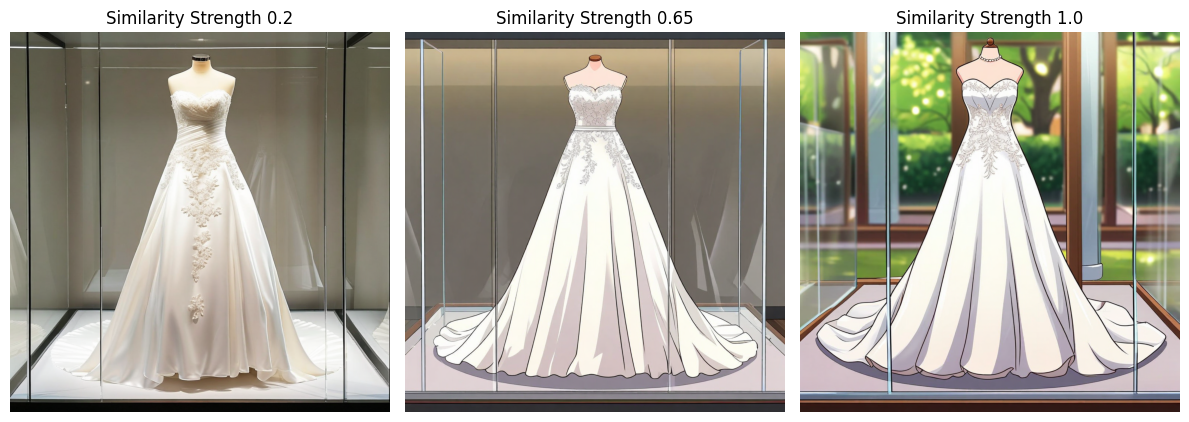

In [7]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Generate image with different similarityStrength values
generated_images = []
for index, similarity_strength in enumerate(similarity_strength_values):
    print(f"Generating image {index+1} of {len(similarity_strength_values)}...")

    response = bedrock_runtime_client.invoke_model(
        body=json.dumps(
            {
                "taskType": "IMAGE_VARIATION",
                "imageVariationParams": {
                    "text": text,
                    "images": [reference_image_base64],  # Up to 5 reference images
                    "similarityStrength": similarity_strength,  # How strongly the input images influence the output. From 0.2 through 1.
                },
                "imageGenerationConfig": {
                    "numberOfImages": 1,  # Number of images to generate, up to 5
                    "cfgScale": 6.5,  # How closely the prompt will be followed
                    "seed": seed,
                    "quality": "standard",  # Quality of either "standard" or "premium"
                },
            }
        ),
        modelId=image_generation_model_id,
        accept="application/json",
        contentType="application/json",
    )

    response_body = json.loads(response.get("body").read())

    base64_images = response_body.get("images")
    image_path = f"{output_dir}/05-image-variation_similarity-{similarity_strength}.png"
    save_image(base64_images[0], image_path)
    print(f"Saving to {image_path}")

    generated_img = [
        Image.open(io.BytesIO(base64.b64decode(base64_image)))
        for base64_image in base64_images
    ]
    generated_images.append(generated_img[0])

# Plot comparison images
plot_images_for_comparison(
    generated_images=generated_images,
    labels=similarity_strength_values,
    prompt=text,
    comparison_mode=True,
    title_prefix="Similarity Strength",
)

It can be seen that when using lower `similarityStrength` value, the generated image will primarily follow the content of the text prompt, with only a subtle influence from the reference image's style. As the value increases, the reference image's style becomes more dominant, potentially overriding some aspects of the text prompt's content.

You should adjust this parameter based on your desired balance between content and style, considering the specific text prompt and reference image being used.


## Take Away


Image variation feature opens up a world of creative possibilities for generating images with specific styles and variations. We encourage you to explore this feature and unleash your creativity. Experiment with different reference images, text prompts and similarity strengths to discover the endless possibilities of image generation.
